# Gauge Observables

--------------------------------------------------------------------
### TODO:
* [x] Generate multiple chain lengths and deal with loading in from multiple `samples_history` files.
* [x] Implement the same logic for `observables` as for `samples_history`.
* [x] Modify remainder of code below to deal with case where `samples` and `observables` are dictionaries with keys specifying the length of the MCMC chain.
* [x] Re-run the cells below for the remainder of `HMC` directory to get ESS values for comparing against ESS from L2HMC.
* [x] Try training sampler for >> 1000 steps and running the trained sampler for a variety of different chain lengths to see what the integrated autocorrelation time approaches as  $N_{steps} \longrightarrow \infty$.
--------------------------------------------------------------------

In [1]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from scipy.stats import sem
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from pandas.plotting import autocorrelation_plot
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
COLORS = 5 * ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = 5 * ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'P', 'D']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

tf.enable_eager_execution()
tfe = tf.contrib.eager

/usr/local/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  obj_type='module')


In [2]:
from scipy.stats import sem
import utils.file_io as io
from lattice.lattice import GaugeLattice, u1_plaq_exact
from gauge_model import GaugeModel
from utils.file_io import save_params_to_pkl_file
from utils.plot_helper import plot_multiple_lines
from utils.autocorr import *
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

%autoreload 2
%matplotlib notebook

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

## Helper functions

### FILE I/O

In [4]:
def check_else_make_dir(d):
    if not os.path.isdir(d):
        print(f"Making directory: {d}")
        os.makedirs(d)

#### Helpers for locating and loading observables and run_data

In [5]:
def get_run_dirs(log_dir):
    run_dir_root = os.path.join(log_dir, 'runs')
    contents = os.listdir(run_dir_root)
    runs_dirs = [
        os.path.join(run_dir_root, i) for i in contents if 'steps' in i
    ]
    params = []
    for d in runs_dirs:
        d_arr = d.split('/')[-1].split('_')
        params.append((int(d_arr[1]), d_arr[-1]))
    return runs_dirs, params

In [6]:
def load_chains(run_dir):
    assert os.path.isdir(run_dir)
    samples_file = os.path.join(run_dir, 'run_samples.pkl')
    if os.path.isfile(samples_file):
        with open(samples_file, 'rb') as f:
            samples = pickle.load(f)
    return samples

In [7]:
def load_run_data(run_dir):
    assert os.path.isdir(run_dir)
    run_data_file = os.path.join(run_dir, 'run_data.pkl')
    print('Loading run_data from: {}'.format(run_data_file))
    with open(run_data_file, 'rb') as f:
        run_data = pickle.load(f)
    return run_data

In [17]:
def load_observables_stats(run_dir):
    assert os.path.isdir(run_dir)
    obs_dir = os.path.join(run_dir, 'observables')
    assert os.path.isdir(obs_dir)
    _files = os.listdir(obs_dir)
    obs_files = [i for i in _files if i.endswith('.pkl')]
    observables = {}
    stats = {}
    for f in obs_files:
        key = f.rstrip('.pkl')
        in_file = os.path.join(obs_dir, f)
        if 'stats' in f:
            with open(in_file, 'rb') as f:
                stats[key] = pickle.load(f)
        else:
            with open(in_file, 'rb') as f:
                observables[key] = pickle.load(f)
    return observables, stats

### Data helpers / autocorrelation helper

In [9]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [10]:
def arrs_from_dict(d):
    assert isinstance(d, dict)
    keys_arr = np.array(list(d.keys()))
    vals_arr = np.array(list(d.values()))
    return keys_arr, vals_arr

### Plotting functions

In [11]:
def plot_observables(observables, hmc=False, out_dir=None, filetype='png'):
    actions_arr, plaqs_arr, charges_arr = observables
    steps_arr = np.arange(actions_arr.shape[0])
    # Total actions plots
    if not hmc:
        title_str = (
            f"L2HMC: "
            r"$\beta = $"
            f"{beta}"#", {run_steps} eval steps"
        )
    else:
        title_str = (
            f"HMC: "
            r"$\beta = $"
            f"{beta}"#", {run_steps} train steps"
        )
    kwargs = {
        'out_file': None,
        'markers': False,
        'lines': True,
        'alpha': 0.6,
        'title': title_str,
        'legend': False,
        'ret': False,
    }
    if out_dir is not None:
        kwargs['out_file'] = os.path.join(out_dir, 
                                          f'actions_vs_step.{filetype}')
    plot_multiple_lines(steps_arr, actions_arr.T,  x_label='Step', 
                        y_label='Total action', **kwargs)
    
    # Average plaquettes plots
    kwargs['ret'] = True
    kwargs['out_file'] = None
    _, ax = plot_multiple_lines(steps_arr, plaqs_arr.T, x_label='Step',
                                y_label='Avg. plaquette', **kwargs)

    _ = ax.axhline(y=u1_plaq_exact(beta),
                   color='#CC0033', ls='-', lw=2.5, label='exact')

    _ = ax.plot(steps_arr, plaqs_arr.T.mean(axis=0),
                color='k', label='average', alpha=0.75)
    if out_dir is not None:
        out_file = os.path.join(out_dir, f'plaqs_vs_step.{filetype}')
        print(f'Saving figure to: {out_file}.')
        plt.savefig(out_file, dpi=400, bbox_inches='tight')
        
    # Topological charge plots
    kwargs['markers'] = True
    kwargs['lines'] = False
    kwargs['alpha'] = 1.
    kwargs['ret'] = False
    if out_dir is not None:
        out_file = os.path.join(out_dir, f'top_charge_vs_step.{filetype}')
    plot_multiple_lines(steps_arr, charges_arr.T, x_label='Step',
                        y_label='Topological charge', **kwargs)

In [12]:
def plot_charge_probs(charges_arr, beta, params, out_dir=None, training=False,
                      hmc=False):
    if not hmc:
        title_str = (
            f"L2HMC: "
            r"$\beta = $"
            f"{beta}, {run_steps} eval steps"
        )
    else:
        title_str = (
            f"HMC: "
            r"$\beta = $"
            f"{beta}, {run_steps} train steps"
        )
        
    if out_dir is not None:
        os.makedirs(out_dir)
        
    num_samples = params['num_samples']
    charges = np.array(charges_arr, dtype=int)
    _run_steps = charges.shape[0]

    # if we have more than 5 samples per batch, only plot first 5
    for idx in range(5):
        counts = Counter(charges[:, idx])
        total_counts = np.sum(list(counts.values()))
        _, ax = plt.subplots()
        ax.plot(list(counts.keys()),
                np.array(list(counts.values()) / total_counts),
                marker=MARKERS[idx],
                color=COLORS[idx],
                ls='',
                label=f'sample {idx}')
        _ = ax.legend(loc='best')
        _ = ax.set_xlabel('Topological charge', fontsize=14)
        _ = ax.set_ylabel('Probability', fontsize=14)
        _ = ax.set_title(title_str, fontsize=16)
        if out_dir is not None:
            out_file = os.path.join(out_dir,
                                    f'top_charge_prob_vs_val_{idx}.png')
            io.log(f'Saving figure to: {out_file}.')
            _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
        #plt.close('all')

    all_counts = Counter(list(charges.flatten()))
    total_counts = np.sum(list(counts.values()))
    _, ax = plt.subplots()
    ax.plot(list(all_counts.keys()),
            np.array(list(all_counts.values()) / (total_counts * num_samples)),
            marker='o',
            color='C0',
            ls='',
            alpha=0.6,
            label=f"total across {num_samples} samples");
    _ = ax.legend(loc='best')
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Probability', fontsize=14)
    _ = ax.set_title(title_str, fontsize=16)
    if out_dir is not None:
        out_file = os.path.join(out_dir,
                                f'TOP_CHARGE_FREQUENCY_VS_VAL_TOTAL.png')
        io.log(f'Saving figure to: {out_file}.')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [13]:
def plot_top_charges(top_charges, beta, out_dir=None, hmc=False,
                     filetype='png'):
    """Plot top. charge history vs. step for individual samples."""
    if out_dir is not None:
        out_dir = os.path.join(out_dir, 'top_charge_plots')
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
            
    if not isinstance(top_charges, np.ndarray):
        top_charges = np.array(top_charges)
            
    run_steps = top_charges.shape[0]
    num_samples = top_charges.shape[1]
    if not hmc:
        title_str = (
            f"L2HMC: "
            r"$\beta = $"
            f"{beta}, {run_steps} eval steps"
        )
    else:
        title_str = (
            f"HMC: "
            r"$\beta = $"
            f"{beta}, {run_steps} train steps"
        )
    for idx in range(min(num_samples, 10)):
        _, ax = plt.subplots()
        _ = ax.plot(top_charges[:, idx],
                    marker=MARKERS[idx],
                    color=COLORS[idx],
                    ls='',
                    alpha=0.6,
                    label=f'sample {idx}')
        _ = ax.legend(loc='best')
        _ = ax.set_xlabel('Step', fontsize=14)
        _ = ax.set_ylabel('Topological charge', fontsize=14)
        _ = ax.set_title(title_str, fontsize=16)
        plt.tight_layout()
        if out_dir is not None:
            out_file = os.path.join(out_dir, 
                                    f'top_charge_vs_step_{idx}.{filetype}')
            print(f"Saving figure to {out_file}.")
            plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [14]:
def plot_suscept(suscept_dict, fig_ax_pair=None, x_inset=5., **kwargs):
    if fig_ax_pair is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = fig_ax_pair
    #else:
    #    if len(fig_ax_pair) == 2:
    #        fig, ax = fig_ax_pair
        #elif len(fig_ax_pair) == 3:
        #    fig, ax, axins = fig_ax_pair
        
    for idx, (key, val) in enumerate(suscept_dict.items()):
        beta = key
        suscept, err = val
        if idx == 0:
            _ = ax.errorbar(beta, suscept, yerr=factor*err, **kwargs)
            #_ = ax.plot(beta, suscept, **plt_kwargs)
        else:
            kwargs['label'] = ''
            _ = ax.errorbar(beta, suscept, yerr=factor*err, **kwargs)
            #_ = ax.plot(beta, suscept, **plt_kwargs)
    #if axins is None:
    #    axins = inset_axes(ax, width="30%", height="40%", loc=1, borderpad=1.5)
        
    #suscept5, err5 = suscept_dict[5.0]
    #_ = axins.errorbar(x_inset, suscept5, yerr=factor*err5, **kwargs)

    #x1, x2, y1, y2 = 4.97, 5.03, 0.005, 0.0065
    #_ = axins.set_xlim(x1, x2)
    #_ = axins.set_ylim(y1, y2)
    return fig, ax #, axins

In [15]:
def plot_individual_observables(figs_dir, observables, top_charges_autocorr):
    multiple_lines_figs_axes = make_multiple_lines_plots(
        figs_dir,
        params['beta_final'],
        observables,
        top_charges_autocorr,
        legend=False
    )
    return multiple_lines_figs_axes

In [16]:
def plot_individual_acf_iat(acf_arr, iat_arr, ess_arr, figs_dir):
    out_file = os.path.join(
        figs_dir, 
        'integrated_autocorrelation_time_plot.pdf'
    )
    kwargs = {
        'x_label': 'Lag',
        'y_label': 'Autocorrelation (top. charge)',
        'legend': True,
        'out_file': out_file
    }
    fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ess_arr, **kwargs)
    
    return fig, ax

## Observables analysis

### Define unique `log_dir` from which to load observables from.

In [42]:
dir_str = ('../../logs/cooley_logs/april_2019/2019_04_24/'
           'lattice16_steps5_batch128_beta25_qweight0/run_1/')
dir_str_hmc = dir_str + 'HMC/run_1/'
log_dir = os.path.join(*dir_str.split('/'))
log_dir_hmc = os.path.join(*dir_str_hmc.split('/'))
params_strs = dir_str.split('/')[5].split('_')
assert os.path.isdir(log_dir)
assert os.path.isdir(log_dir_hmc)

In [43]:
run_dirs, run_params = get_run_dirs(log_dir)
run_dirs_hmc, run_params_hmc = get_run_dirs(log_dir_hmc)

run_dirs
run_dirs_hmc

['../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/runs/steps_25000_beta_4.0',
 '../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/runs/steps_25000_beta_5.0',
 '../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/runs/steps_25000_beta_6.0']

['../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/HMC/run_1/runs/steps_25000_beta_4.0',
 '../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/HMC/run_1/runs/steps_25000_beta_5.0',
 '../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/HMC/run_1/runs/steps_25000_beta_6.0']

Loop over all directories in `run_dirs` and `run_dirs_hmc`, and append the topological charge autocorrelations to `charges_autocorrs` and `charges_autocorrs_hmc`.

In [44]:
def charges_autocorrs_from_run_dirs(run_dirs):
    charges_autocorrs_dict = {} 
    for d in run_dirs:
        beta = float(d.split('/')[-1].split('_')[-1])
        run_data = load_run_data(d)
        _, charges_arr = arrs_from_dict(run_data['charges'])
        charge_autocorrs = np.array([autocorr(i) for i in charges_arr.T])
        charges_autocorrs_dict[beta] = charge_autocorrs
        #charges_autocorrs.append(charge_autocorrs)
        
    return charges_autocorrs_dict

In [45]:
def load_charges_from_run_dirs(run_dirs):
    charges_autocorrs_dict = {}
    for d in run_dirs:
        obs_dir = os.path.join(d, 'observables')
        charges_file = os.path.join(obs_dir, 'charges.pkl')
        with open(charges_file, 'rb') as f:
            charges_arr = pickle.load(f)
        beta = float(d.split('/')[-1].split('_')[-1])

In [46]:
charges_autocorrs_dict = charges_autocorrs_from_run_dirs(run_dirs)
charges_autocorrs_dict_hmc = charges_autocorrs_from_run_dirs(run_dirs_hmc)

Loading run_data from: ../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/runs/steps_25000_beta_4.0/run_data.pkl
Loading run_data from: ../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/runs/steps_25000_beta_5.0/run_data.pkl
Loading run_data from: ../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/runs/steps_25000_beta_6.0/run_data.pkl
Loading run_data from: ../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/HMC/run_1/runs/steps_25000_beta_4.0/run_data.pkl
Loading run_data from: ../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/HMC/run_1/runs/steps_25000_beta_5.0/run_data.pkl
Loading run_data from: ../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/HMC/run_1/runs/steps_25000_beta_6.0/run_data.pkl


### Plot Topological Charge $Q$ Autocorrelations (L2HMC, HMC) for multiple values of $\beta$.

<IPython.core.display.Javascript object>


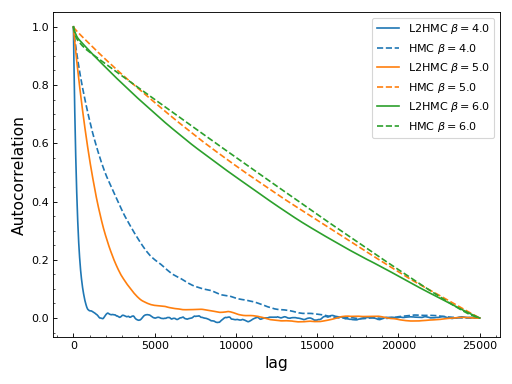

Saving figure to: ../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/figures/top_charge_autocorrelations.eps.
Saving figure to: ../../logs/cooley_logs/april_2019/2019_04_24/lattice16_steps5_batch128_beta25_qweight0/run_1/figures/top_charge_autocorrelations.png.


In [47]:
figs_dir = os.path.join(log_dir, 'figures')
if not os.path.isdir(figs_dir):
    os.makedirs(figs_dir)
   
fig, ax = plt.subplots()
for idx, beta in enumerate(charges_autocorrs_dict.keys()):
    acorr_l2hmc = charges_autocorrs_dict[beta]
    acorr_avg_l2hmc = acorr_l2hmc.mean(axis=0)
    acorr_max_l2hmc = acorr_avg_l2hmc.max()
    
    acorr_hmc = charges_autocorrs_dict_hmc[beta]
    acorr_avg_hmc = acorr_hmc.mean(axis=0)
    acorr_max_hmc = acorr_avg_hmc.max()
    l2hmc_label = 'L2HMC ' + r"""$\beta = $""" + f'{beta}'
    hmc_label = 'HMC ' + r"""$\beta = $""" + f'{beta}'

    _ = ax.plot(acorr_avg_l2hmc / acorr_max_l2hmc, 
                ls='-', color=COLORS[idx],  label=l2hmc_label)
    _ = ax.plot(acorr_avg_hmc / acorr_max_hmc,
                ls='--', color=COLORS[idx], label=hmc_label)
    
_ = ax.legend(loc='best')
_ = ax.set_xlabel('lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation', fontsize=14)
_ = fig.tight_layout()

out_file1 = os.path.join(figs_dir, 'top_charge_autocorrelations.eps')
out_file2 = os.path.join(figs_dir, 'top_charge_autocorrelations.png')
print(f"Saving figure to: {out_file1}.")
_ = plt.savefig(out_file1, dpi=400, bbox_inches='tight')
print(f"Saving figure to: {out_file2}.")
_ = plt.savefig(out_file2, dpi=400, bbox_inches='tight')

In [ ]:
figs_dir = os.path.join(log_dir, 'figures')
if not os.path.isdir(figs_dir):
    os.makedirs(figs_dir)

beta = 5.0
acorr_l2hmc = charges_autocorrs_dict[beta]
acorr_avg_l2hmc = acorr_l2hmc.mean(axis=0)
acorr_max_l2hmc = acorr_avg_l2hmc.max()
acorr_hmc = charges_autocorrs_dict_hmc[beta]
acorr_avg_hmc = acorr_hmc.mean(axis=0)
acorr_max_hmc = acorr_avg_hmc.max()
l2hmc_label = 'L2HMC ' + r"""$\beta = $""" + f'{beta}'
hmc_label = 'HMC ' + r"""$\beta = $""" + f'{beta}'

fig, ax = plt.subplots()
_ = ax.plot(acorr_avg_l2hmc / acorr_max_l2hmc, 
            ls='-', color=COLORS[0],  label=l2hmc_label)
_ = ax.plot(acorr_avg_hmc / acorr_max_hmc,
            ls='--', color=COLORS[0], label=hmc_label)
_ = ax.legend(loc='best')
_ = ax.set_xlabel('lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation', fontsize=14)
_ = fig.tight_layout()
out_file1 = os.path.join(figs_dir, 'top_charge_autocorrelations.eps')
out_file2 = os.path.join(figs_dir, 'top_charge_autocorrelations.png')
print(f"Saving figure to: {out_file1}.")
_ = plt.savefig(out_file1, dpi=400, bbox_inches='tight')
print(f"Saving figure to: {out_file2}.")
_ = plt.savefig(out_file2, dpi=400, bbox_inches='tight')

In [ ]:
num_samples = charge_autocorrs.shape[0]

fig, ax = plt.subplots()
    
avg_l2hmc = charge_autocorrs.mean(axis=0)
max_l2hmc = avg_l2hmc.max()
avg_hmc = charge_autocorrs_hmc.mean(axis=0)
max_hmc = avg_hmc.max()

ax.plot(avg_l2hmc / max_l2hmc,  #color='k', ls='-', lw=2.,
        label='L2HMC (avg. over {} samples)'.format(num_samples))
ax.plot(avg_hmc / max_hmc,
        #color='k', ls='-', lw=2.,
        label='HMC (avg. over {} samples)'.format(num_samples))
ax.legend(loc='best')
ax.set_xlabel('lag', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)

## Load chains

In [ ]:
run_dir = run_dirs[0]
run_dir_hmc = run_dirs_hmc[0]

chains = np.array(load_chains(run_dir))
chains_hmc = np.array(load_chains())

In [ ]:
def lattice_autocorr(chain):
    """Calc avg. autocorrelation over all individual links on the lattice."""
    num_links = chain.shape[-1]
    links_autocorr = [autocorr(i) for i in chain.T]
    links_autocorr_avg = np.mean(links_autocorr, axis=0)
    return links_autocorr_avg

chains = np.array(load_chains(run_dir))
chains_hmc = np.array(load_chains(run_dir_hmc))

#chain = chains[:, 0, :]
#num_links = chain.shape[-1]
#links_autocorr = np.array([autocorr(i) for i in chain.T])
#links_autocorr_avg = np.mean(links_autocorr, axis=0)
#links_autocorr_avg = np.mean(links_autocorr.shape)

#lattice_autocorrs = [
#    lattice_autocorr(i) for i in chains.transpose((1, 0, -1))
#]
#lattice_autocorrs_hmc = [
#    lattice_autocorr(i) for i in chains_hmc.transpose((-1, 0, 1))
#]

#### Look at the autocorrelation of individual links on the lattice (poor indicator)

In [ ]:
lattice_autocorrs = np.array(lattice_autocorrs)
lattice_autocorrs_hmc = np.array(lattice_autocorrs_hmc)

fig, ax = plt.subplots()
#for idx in range(20):
#    ax.plot(charge_autocorrs[idx] / charge_autocorrs[idx].max(), ls='--')
    
avg_l2hmc = lattice_autocorrs.mean(axis=0)
max_l2hmc = avg_l2hmc.max()
avg_hmc = lattice_autocorrs.mean(axis=0)
max_hmc = avg_hmc.max()

ax.plot(avg_l2hmc / max_l2hmc,  #color='k', ls='-', lw=2.,
        label='L2HMC (avg. over {} samples)'.format(num_samples))
ax.plot(avg_hmc / max_hmc,
        #color='k', ls='-', lw=2.,
        label='HMC (avg. over {} samples)'.format(num_samples))
ax.legend(loc='best')
ax.set_xlabel('lag', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)

##### Define multiple `log_dir`'s with different lattice sizes for plotting the topological susceptibility.

In [ ]:
log_dir16 = os.path.join('..', '..', 'logs', '2019_04_10', 'lattice_L16', 
                          'num_steps3', 'num_samples32', 'beta_i2_f5', 
                          'charge_weight0', 'run_1')
log_dir16_hmc = os.path.join('..', '..', 'logs', 'HMC', 'runs_L16',
                             'num_steps3', 'eps02094', 'num_samples32',
                             'beta_i1_f5', 'run_1')
#log_dir16_hmc = os.path.join(log_dir16, 'HMC', 'run_1')
assert os.path.isdir(log_dir16)
assert os.path.isdir(log_dir16_hmc)

log_dir12 = os.path.join('..', '..', 'logs', '2019_04_10', 'lattice_L12', 
                          'num_steps5', 'num_samples50', 'beta_i2_f5', 
                          'charge_weight0', 'run_1')
#log_dir12_hmc = os.path.join(log_dir12, 'HMC', 'run_1')
log_dir12_hmc = os.path.join('..', '..', 'logs', 'HMC', 'runs_L12', 
                             'num_steps5', 'eps02097', 'num_samples50',
                             'beta_i1_f5', 'run_2')
assert os.path.isdir(log_dir12)
assert os.path.isdir(log_dir12_hmc)

log_dir8 = os.path.join('..', '..', 'logs', '2019_04_08', 'lattice_L8', 
                        'num_steps5',  'num_samples64', 'beta_i2_f45', 
                        'charge_weight0', 'run_1')
log_dir8_hmc = os.path.join('..', '..', 'logs', 'HMC', 'runs_L8',
                            'num_steps5', 'eps0228', 'num_samples64',
                            'beta_i1_f5', 'run_1')
#log_dir8_hmc = os.path.join(log_dir8, 'HMC', 'run_3')
assert os.path.isdir(log_dir8)
assert os.path.isdir(log_dir8_hmc)

In [ ]:
output16 = get_observables(log_dir16)
output16_hmc = get_observables(log_dir16_hmc)

output12 = get_observables(log_dir12)
output12_hmc = get_observables(log_dir12_hmc)

output8 = get_observables(log_dir8)
output8_hmc = get_observables(log_dir8_hmc)

In [ ]:
def get_xy(suscept, offset):
    x = np.array(list(suscept.keys())) + offset
    xx = np.array(list(suscept.keys())) 
    y = np.array(list(suscept.values()))[:, 0]
    err = np.array(list(suscept.values()))[:, 1]
    return x, xx, y, err

In [ ]:
suscept8 = output8['observables']['dicts']['suscept']
suscept8_hmc = output8_hmc['observables']['dicts']['suscept']
suscept12 = output12['observables']['dicts']['suscept']
suscept12_hmc = output12_hmc['observables']['dicts']['suscept']
suscept16 = output16['observables']['dicts']['suscept']
suscept16_hmc = output16_hmc['observables']['dicts']['suscept']

offsets = 2 * np.array([0., 0.015, 0.03, 0.045, 0.06, 0.075, 0.1])
x16, xx16, y16, y16_err = get_xy(suscept16, offsets[0])
x16_hmc, xx16_hmc, y16_hmc, y16_hmc_err = get_xy(suscept16_hmc, offsets[1])
x12, xx12, y12, y12_err = get_xy(suscept12, offsets[2])
x12_hmc, xx12_hmc, y12_hmc, y12_hmc_err = get_xy(suscept12_hmc, offsets[3])
x8, xx8, y8, y8_err = get_xy(suscept8, offsets[4])
x8_hmc, xx8_hmc, y8_hmc, y8_hmc_err = get_xy(suscept8_hmc, offsets[5])


ys = [y16, y16_hmc, y12, y12_hmc, y8, y8_hmc]
xs = [x16, x16_hmc, x12, x12_hmc, x8, x8_hmc]
xxs = [xx16, xx16_hmc, xx12, xx12_hmc, xx8, xx8_hmc]
xxs = [xx16, xx16_hmc, xx12, xx12_hmc, xx8, xx8_hmc]
errs = [y16_err, y16_hmc_err, y12_err, y12_hmc_err, y8_err, y8_hmc_err]

In [ ]:
labels = []
markers = []
colors = []

fig_ax = plt.subplots()
kwargs = {
    'label': 'L2HMC $L=16$',
    'marker': 's',
    'markersize': 8.,
    'color': 'C0',
    'alpha': 0.8,
    'capsize': 4.,
    'capthick': 1.5,
    #'fillstyle': 'none'
}
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept16, fig_ax, x_inset=offsets[1], **kwargs)

kwargs['label'] = 'HMC $L=16$' # ' + r"""$L = 12$"""
kwargs['marker'] = 's'
kwargs['color'] = 'C0'
kwargs['alpha'] = 1.
kwargs['fillstyle'] = 'none'
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept16_hmc, fig_ax, x_inset=offsets[2], **kwargs)

kwargs['label'] = 'L2HMC $L=12$' # + r"""$L = 16$"""
kwargs['marker'] = 'o'
kwargs['color'] = 'C2'
kwargs['alpha'] = 0.8
kwargs['fillstyle'] = 'full'
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept12, fig_ax, x_inset=offsets[1], **kwargs)

kwargs['label'] = 'HMC $L=12$' #  ' + r"""$L = 8$"""
kwargs['color'] = 'C2'
kwargs['marker'] = 'o'
kwargs['fillstyle'] = 'none'
kwargs['alpha'] = 1.
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept12_hmc, fig_ax, x_inset=offsets[3], **kwargs)

kwargs['label'] = 'L2HMC $L=8$' #  ' + r"""$L = 8$"""
kwargs['color'] = 'C3'
kwargs['marker'] = 'd'
kwargs['fillstyle'] = 'full'
kwargs['alpha'] = 0.8
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept8, fig_ax, x_inset=offsets[0], **kwargs)

kwargs['label'] = 'HMC $L=8$' #  ' + r"""$L = 8$"""
kwargs['color'] = 'C3'
kwargs['marker'] = 'd'
kwargs['alpha'] = 1.
kwargs['fillstyle'] = 'none'
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept8_hmc, fig_ax, x_inset=offsets[3], **kwargs)

axins = inset_axes(fig_ax[1], width="25%", height="40%", loc='upper center', borderpad=1.25)
axins1 = inset_axes(fig_ax[1], width="25%", height="40%", loc='upper right', borderpad=1.25)
fmts = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
alphas = [0.8, 1., 0.8, 1., 0.8, 1., 0.8, 1.]
linestyles = ['-', '--', '-', '--', '-', '--']
fillstyles = ['full', 'none', 'full', 'none', 'full', 'none']
for idx, (x, y) in enumerate(zip(xs, ys)):
    _ = fig_ax[1].plot(xxs[idx], y, color=colors[idx], label=labels[idx],
                       ls=linestyles[idx], fillstyle=fillstyles[idx], alpha=alphas[idx],
                       marker=markers[idx], markersize=kwargs['markersize'])#, lw=1.)
    _ = axins.errorbar(xs[idx], y, yerr=errs[idx], ls='',
                       marker=markers[idx], fillstyle=fillstyles[idx],
                       color=colors[idx], capsize=4., capthick=1.25)
    _ = axins1.errorbar(xs[idx], y, yerr=errs[idx], ls='',
                        marker=markers[idx], fillstyle=fillstyles[idx],
                        color=colors[idx], capsize=4., capthick=1.25)
    
fig, ax = fig_ax
_ = ax.tick_params(labelsize=12)
_ = ax.set_xlabel(r"""$\beta$""", fontsize=18)
_ = ax.set_ylabel(r"""$\chi$""", fontsize=18)
_ = ax.legend(loc='lower left')#, fontsize=12)

x1, x2, y1, y2 = 3.95, 4.2, 0.0072, 0.0079
_ = axins.set_xlim(x1, x2)
_ = axins.set_ylim(y1, y2)
_ = axins.grid('on')
_ = axins.tick_params(labelsize=12)
_ = axins.ticklabel_format(style='sci', scilimits=(-2, 2),
                           useMathText=False)
x1, x2, y1, y2 = 4.95, 5.2, 0.0052, 0.0063
_ = axins1.set_xlim(x1, x2)
_ = axins1.set_ylim(y1, y2)
_ = axins1.grid('on')
_ = axins1.tick_params(labelsize=12)
_ = axins1.ticklabel_format(style='sci', scilimits=(-2, 2),
                            useMathText=False)
axins.set_xticks([4.075])
axins.set_xticklabels(['4.0'])
axins1.set_xticks([5.075])
axins1.set_xticklabels(['5.0'])

_ = plt.tight_layout()
out_dir = os.path.join('..', '..', '..', 'writeup',
                       'l2hmc_writeup', 'figures', 'suscept_plots')
io.check_else_make_dir(out_dir)
suscept_files = [
    i for i in os.listdir(out_dir) if i.startswith('topological_suscept_vs_beta_all_')
]
try:
    file_num = int(sorted(
        [i.split('_')[-1][:-4] for i in suscept_files]
    )[-1]) + 1
except IndexError:
    file_num = 1

out_file = os.path.join(out_dir, f'topological_suscept_vs_beta_all_{file_num}.eps')
print(f'Saving figure to: {out_file}.')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
xs_ = np.copy(xs)
for i in xs_:
    i[-2] -= 0.25
    i[-1] += 0.25
#[i[-2] + 0.25 for i in xxs]
#[i[-1] - 0.25 for i in xxs]
xs

In [ ]:
file_num = sorted([i.split('_')[-1].rstrip('.eps') for i in suscept_files])[-1] + 1
out_file = os.path.join(out_dir, f'topological_suscept_vs_beta_all_{file_num}.eps')

out_file = os.path.join(out_dir, 'topological_suscept_vs_beta_L8_12_16_1.eps')

file_name = out_file.split('/')[-1]
file_num = int(file_name.split('_')[-1].rstrip('.eps'))
file_num += 1
_file_name = file_name.rstrip(str(file_num-1) + '.eps')
file_name = _file_name + str(file_num) + '.eps'
file_name

from scipy.stats import sem
charges_dict = {}
actions_dict = {}
plaqs_dict = {}
volume = params['time_size'] * params['space_size']
print("time_size: {}".format(params['time_size']))
print("space_size: {}".format(params['space_size']))
print("num_steps: {}".format(params['num_steps']))
print("num_samples: {}".format(params['num_samples']))
      

for idx, d in enumerate(obs_dirs):
    output = load_stats_and_observables(d)
    _actions_dict, _plaqs_dict, _charges_dict, tun_events = output
    actions_arr = np.array(list(_actions_dict.values()))
    plaqs_arr = np.array(list(_plaqs_dict.values()))
    charges_arr = np.array(list(_charges_dict.values()))
    
    keys_arr = np.array(list(_actions_dict.keys()))
    steps_arr = keys_arr[:, 0]
    beta = betas[idx]
    run_steps = charges_arr.shape[0]
    
    key = (run_steps, beta)
    charges_dict[key] = charges_arr
    actions_dict[key] = actions_arr
    plaqs_dict[key] = plaqs_arr

suscept_dict = {}
for key, val in charges_dict.items():
    beta = key[1]
    suscept_dict[beta] = np.mean(val ** 2, axis=0) / volume

charges_dict_hmc = {}
actions_dict_hmc = {}
plaqs_dict_hmc = {}

for idx, d in enumerate(obs_dirs_hmc):
    output = load_stats_and_observables(d)
    _actions_dict, _plaqs_dict, _charges_dict, tun_events = output
    actions_arr = np.array(list(_actions_dict.values()))
    plaqs_arr = np.array(list(_plaqs_dict.values()))
    charges_arr = np.array(list(_charges_dict.values()))
    
    keys_arr = np.array(list(_actions_dict.keys()))
    steps_arr = keys_arr[:, 0]
    beta = betas[idx]
    run_steps = charges_arr.shape[0]
    
    key = (run_steps, beta)
    charges_dict_hmc[key] = charges_arr
    actions_dict_hmc[key] = actions_arr
    plaqs_dict_hmc[key] = plaqs_arr

suscept_dict_hmc = {}
for key, val in charges_dict_hmc.items():
    beta = key[1]
    suscept_dict_hmc[beta] = np.mean(val ** 2, axis=0)

In [ ]:
ax.tick_params(labelsize=12)

_ = ax.set_xlabel(r"""$\beta$""", fontsize=18)
_ = ax.set_ylabel(r"""$\chi$""", fontsize=18)
_ = ax.legend(loc='best', fontsize=16)

_figs_dir = os.path.join(log_dir, 'figures_orig')
out_file = os.path.join(_figs_dir, 'topological_suscept_vs_beta_both.eps')
_ = plt.tight_layout()
print(f'Saving figure to: {out_file}.')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
obs_arrs8 = output8['observables']['arrs']

_log_dir8_1 = '../../logs/conv3D_logs/lattice_L8/old_charge_loss/num_steps5/eps_init03/num_samples64/beta_i2_f5/lr_init1e-3/charge_weight1/run_2/'
#..,..,logs,conv3D_logs,lattice_L8,old_charge_loss,num_steps5,eps_init03,num_samples64,beta_i2_f5,lr_init1e-3,charge_weight1,run_2,
_log_dir8_0= '../../logs/conv3D_logs/lattice_L8/old_charge_loss/num_steps5/eps_init03/num_samples64/beta_i2_f5/lr_init1e-3/charge_weight0/run_4/'

_output8_1 = get_observables(_log_dir8_1)
_output8_0 = get_observables(_log_dir8_0)

obs_arrs8_1 = _output8_1['observables']['arrs']
obs_arrs8_0 = _output8_0['observables']['arrs']

keys_arr8_1 = np.array(list(_output8_1['observables']['dicts']['actions'].keys()))
keys_arr8_0 = np.array(list(_output8_0['observables']['dicts']['actions'].keys()))
keys_arr8_1 == keys_arr8_0
steps_arr = keys_arr[:, 0]

#out_dir = output8['fi']
obs8_1 = (obs_arrs8_1['actions'], obs_arrs8_1['plaqs'], obs_arrs8_1['charges'])
obs8_0 = (obs_arrs8_0['actions'], obs_arrs8_0['plaqs'], obs_arrs8_0['charges'])

steps_arr = np.arange(25000)

In [ ]:
out_dir = '../../../writeup/l2hmc_writeup/figures/plaq_plots/good_converge/'
io.check_else_make_dir(out_dir)
plot_observables(steps_arr, obs8_0, out_dir=out_dir, filetype='eps', hmc=False)

out_dir = '../../../writeup/l2hmc_writeup/figures/plaq_plots/bad_converge/'
io.check_else_make_dir(out_dir)
plot_observables(steps_arr, obs8_1, out_dir=out_dir, filetype='eps', hmc=False)

out_dir = '../../../writeup/l2hmc_writeup/figures/plaq_plots/'
fig, ax = plt.subplots()
plot_observables()
plot_observables(steps_arr, , out_dir=out_dir, filetype='eps', hmc=False)

In [ ]:
for idx, d in enumerate(obs_dirs):
    output = load_stats_and_observables(d)
    actions_dict, plaqs_dict, charges_dict, tun_events = output
    
    actions_arr = np.array(list(actions_dict.values()))
    plaqs_arr = np.array(list(plaqs_dict.values()))
    charges_arr = np.array(list(charges_dict.values()))

    keys_arr = np.array(list(actions_dict.keys()))
    steps_arr = keys_arr[:, 0]
    beta = betas[idx]
    run_steps = charges_arr.shape[0]
    if not os.path.isdir(figs_dirs[idx]):
        os.makedirs(figs_dirs[idx])
    observables = (actions_arr, plaqs_arr, charges_arr)
    plot_observables(steps_arr, observables, hmc=False,
                     out_dir=figs_dirs[idx], filetype='eps')
    plot_top_charges(charges_arr, beta, out_dir=figs_dir, filetype='eps',
                     hmc=False)
    #out_dir = os.path.join(figs_dirs[idx], 'top_charge_probs')
    #num_samples = params['num_samples']
    #plot_charge_probs(charges_arr, beta, params, out_dir, training=False)

In [ ]:
for idx, d in enumerate(obs_dirs):
    plt.close('all')
    output = load_stats_and_observables(d)
    actions_dict, plaqs_dict, charges_dict, tun_events = output
    
    actions_arr = np.array(list(actions_dict.values()))
    plaqs_arr = np.array(list(plaqs_dict.values()))
    charges_arr = np.array(list(charges_dict.values()))

    keys_arr = np.array(list(actions_dict.keys()))
    steps_arr = keys_arr[:, 0]
    beta = keys_arr[0, 1]
    run_steps = charges_arr.shape[0]
    #run_steps = charges.shape[0]
    if not os.path.isdir(figs_dir):
        os.makedirs(figs_dir)
    observables = (actions_arr, plaqs_arr, charges_arr)
    plot_susceptibility(charges_arr[::5], beta, out_dir=figs_dir, filetype='eps')
    beta = betas[idx]
    #out_dir = os.path.join(figs_dirs[idx], 'top_charge_probs')
    #num_samples = params['num_samples']
    #plot_charge_probs(charges_arr, beta, params, out_dir, training=False)

# OLD

In [ ]:
from gauge_model import create_dynamics

In [ ]:
samples = tf.convert_to_tensor(np.zeros((params['num_samples'],
                                         params['time_size'],
                                         params['space_size'],
                                         params['dim'])))
samples.shape

In [ ]:
x = tf.reshape(samples, (params['num_samples'], -1))
x.shape

In [ ]:
params['eps']

In [ ]:
x_np = np.zeros(x.shape)
x_np.shape

In [ ]:
from lattice.lattice import u1_plaq_exact

In [ ]:
samples_np = np.zeros(samples.shape)
samples_np.shape

In [ ]:
kwargs = {
    'eps': params['eps'],
    'hmc': False,
    'network_arch': None,
    'num_steps': params['num_steps'],
    'eps_trainable': False,
    'data_format': 'channels_last',
    'rand': False,
    'link_type': 'U1',
}
dynamics, potential_fn = create_dynamics(samples_np, **kwargs)

In [ ]:
dynamics_kwargs = {
    'eps': params.get('eps', 0.1),
    'hmc': params.get('hmc', False),
    'network_arch': params.get('network_arch', 'conv3d'),
    'num_steps': params.get('num_steps', 5),
    'eps_trainable': params.get('eps_trainable', True),
    'data_format': params.get('data_format', 'channels_last'),
    'rand': params.get('rand', False),
    'link_type': params.get('link_type')
}
dynamics, potential_fn = create_dynamics(samples_np, **dynamics_kwargs)

In [ ]:
x = np.array(x_np, dtype=np.float32)
x_proposed, _, px, x_out = dynamics(x, beta=5.)

In [ ]:
output =  load_stats_and_observables(obs_dirs[1])
actions_dict, plaqs_dict, charges_dict, tun_events = output

In [ ]:
actions_arr = np.array(list(actions_dict.values()))
plaqs_arr = np.array(list(plaqs_dict.values()))
charges_arr = np.array(list(charges_dict.values()))

keys_arr = np.array(list(actions_dict.keys()))
steps_arr = keys_arr[:, 0]
beta = keys_arr[0, 1]
_run_steps = charges.shape[0]

In [ ]:
charges_arr = np.array(charges_arr, dtype=int)

In [ ]:
from utils.plot_helper import plot_multiple_lines

In [ ]:
observables = (actions_arr, plaqs_arr, charges_arr)
plot_observables(steps_arr, observables, train=False)

In [ ]:
beta = betas[1]
out_dir = os.path.join(figs_dirs[1], 'top_charge_probs')
num_samples = params['num_samples']

plot_charge_probs(charges_arr, beta, params, out_dir, training=False)

In [ ]:
x = np.arange(-4, 4, 1e-4)
y_exact = project_angle(x)
y_slow = linear_fft(x)
y_approx_arr = []
num_terms = [10, 20, 50, 100, 250, 500, 1000]
times = []
for n in num_terms:
    t0 = time.time()
    y_approx_arr.append(linear_fs(x, n))
    dt = time.time() - t0
    print(f'Time to complete ({n} terms): {dt:.4g}')
    times.append(time.time() - t0)

In [ ]:
errs = []
for idx, y in enumerate(y_approx_arr):
    err = sum((y - y_exact)/len(y_exact.numpy()))
    print(f"Error ({num_terms[idx]} terms): {err:.4g}")
    errs.append(err)

In [ ]:
top_charges = int(
    0.1 + (tf.reduce_sum(ps_proj, axis=(1, 2),
                         name='top_charges') / 2 * np.pi)
)


In [ ]:
yy1 = np.array((y_exact / 2 * np.pi), dtype=int)
yy = np.array(y_approx_arr[1] / 2 * np.pi, dtype=int)

In [ ]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(yy)), yy1, label='exact')
ax.plot(np.arange(len(yy)), yy, label='fft')
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
for idx, y in enumerate(y_approx_arr):
    ax.plot(x, y, label = f'{num_terms[idx]} terms', alpha=0.7, ls='-');
ax.plot(x, y_exact, label='Exact', color='k');
ax.legend(loc='best', fontsize=10);
ax.set_xlabel('x');
ax.set_ylabel('y');
#ax.set_xlim((-np.pi-0.05, -np.pi + 0.05))
out_file = os.path.join(os.getcwd(), 'fourier_series_approx_zoom.png');
print(f'Saving figure to: {out_file}.');
plt.savefig(out_file, dpi=400, bbox_inches='tight');
plt.show();

In [ ]:
fig, ax = plt.subplots()
for idx, y in enumerate(y_approx_arr):
    ax.plot(x, y, label = f'{num_terms[idx]} terms', alpha=0.7, ls='-');
ax.plot(x, y_exact, label='Exact', color='k');
ax.legend(loc='best', fontsize=10);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.set_xlim((-np.pi-0.05, -np.pi + 0.05))
out_file = os.path.join(os.getcwd(), 'fourier_series_approx_zoom.png');
print(f'Saving figure to: {out_file}.');
plt.savefig(out_file, dpi=400, bbox_inches='tight');
plt.show();

In [ ]:
def calc_plaq_sums(x, batch_size, links_shape):
    """Calculate plaquette sums.

    Explicitly, calculate the sum of the links around each plaquette in the
    lattice for each sample in samples.

    Args:
        samples: Tensor of shape (N, D) where N is the batch size and D is
        the number of links on the lattice (flattened)
    """
    x = np.reshape(x, shape=(batch_size, *links.shape))

    plaq_sums = (x[:, :, :, 0]
                 - x[:, :, :, 1]
                 - np.roll(x[:, :, :, 0], shift=-1, axis=2)
                 + np.roll(x[:, :, :, 1], shift=-1, axis=1))
    return plaq_sums

In [ ]:
def calc_top_charges(x, batch_size, links_Shape, fn=np.floor):
    """Calculate topological charges for each sample in samples."""
    top_charges = fn(
        0.1 + (np.sum(project_angle(calc_plaq_sums(x)), axis=(1, 2))
               / (2 * np.pi))
    )
    return top_charges

In [ ]:
###############################################
# OLD SUSCEPTIBILITY PLOTTER
###############################################
factor = 1.
labels = []
markers = []
colors = []

fig_ax = plt.subplots()
kwargs = {
    'label': 'L2HMC $L=16$',
    'marker': 's',
    'markersize': 8.,
    'color': 'C0',
    'alpha': 1.,
    'capsize': 4.,
    'capthick': 1.5,
    #'fillstyle': 'none'
}
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept16, fig_ax, x_inset=offsets[1], **kwargs)

kwargs['label'] = 'HMC $L=16$' # ' + r"""$L = 12$"""
kwargs['marker'] = 's'
kwargs['color'] = 'C0'
kwargs['alpha'] = 0.8
kwargs['fillstyle'] = 'none'
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept16_hmc, fig_ax, x_inset=offsets[2], **kwargs)

kwargs['label'] = 'L2HMC $L=12$' # + r"""$L = 16$"""
kwargs['marker'] = 'o'
kwargs['color'] = 'C2'
kwargs['alpha'] = 0.8
kwargs['fillstyle'] = 'full'
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept12, fig_ax, x_inset=offsets[1], **kwargs)


kwargs['label'] = 'HMC $L=12$' #  ' + r"""$L = 8$"""
kwargs['color'] = 'C2'
kwargs['marker'] = 'o'
kwargs['fillstyle'] = 'none'
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept12_hmc, fig_ax, x_inset=offsets[3], **kwargs)

kwargs['label'] = 'L2HMC $L=8$' #  ' + r"""$L = 8$"""
kwargs['color'] = 'C3'
kwargs['marker'] = 'd'
kwargs['fillstyle'] = 'full'
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept8, fig_ax, x_inset=offsets[0], **kwargs)

kwargs['label'] = 'HMC $L=8$' #  ' + r"""$L = 8$"""
kwargs['color'] = 'C3'
kwargs['marker'] = 'd'
kwargs['fillstyle'] = 'none'
labels.append(kwargs['label'])
markers.append(kwargs['marker'])
colors.append(kwargs['color'])
kwargs['label'] = ''
fig_ax = plot_suscept(suscept8_hmc, fig_ax, x_inset=offsets[3], **kwargs)

axins = inset_axes(fig_ax[1], width="55%", height="55%", loc=1, borderpad=1.25)
#axins = zoomed_inset_axes(fig_ax[1], zoom=5.1, loc=1, borderpad=1.5)
fmts = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
linestyles = ['-', '--', '-', '--', '-', '--']
fillstyles = ['full', 'none', 'full', 'none', 'full', 'none']
#q = 1.
alphas = [1., 0.9, 0.8, 0.7]
#plt.rc('font', size=8)
for idx, (x, y) in enumerate(zip(xs, ys)):
    #if idx != 1:
    #    xx = x + 0.00001
    #else:
    #    xx = x + (0.00001 / 2)
    fig_ax[1].plot(xxs[idx], y, color=colors[idx], ls=linestyles[idx], label=labels[idx],
                   fillstyle=fillstyles[idx],
                   marker=markers[idx], markersize=kwargs['markersize'])#, lw=1.)
    #fig_ax[1].plot(x_avgs, avgs, color='k', ls='-', alpha=0.7)
    axins.errorbar(x, y, yerr=errs[idx], marker=markers[idx], ls='',
                   fillstyle=fillstyles[idx],
                   #ls=linestyles[idx], lw=1.2,
                   #alpha=0.8,
                   #fillstyle='none',
                   #markersize=1.5*kwargs['markersize'], fillstyle='none',
                   color=colors[idx], capsize=4., capthick=1.25)
                   #alpha=alphas[idx]) #linestyle=linestyles[idx])
    #q += 2
    #axins.plot(x, y, fmts[idx], alpha=0.7, lw=1.)
    
x1, x2, y1, y2 = 3.95, 5.2, 0.0049, 0.0078
_ = axins.set_xlim(x1, x2)
_ = axins.set_ylim(y1, y2)
_ = axins.grid('on')

#plt.rc('font', size=8)
axins.ticklabel_format(style='sci', scilimits=(-2, 2), useMathText=False)
_ = axins.tick_params(labelsize=12)
#plt.rc('font', size=12)
    
fig, ax = fig_ax
#axins = zoomed_inset_axes(ax, zoom=1.1, width="30%", height="40%", loc=1, borderpad=1.5)
#axins = inset_axes(ax, width="30%", height="40%", loc=1, borderpad=1.5)

#Axes.ticklabel_format(*, axis='both', style='', scilimits=None, 
#                      useOffset=None, useLocale=None, useMathText=None)¶
#tt = np.arange(1., 5., 0.05)


plt.rc('font', size=10)
#ax.ticklabel_format(style='sci', scilimits=(-2, 2))#, useMathText=True)
_ = ax.tick_params(labelsize=12)
_ = ax.set_xlabel(r"""$\beta$""", fontsize=18)
_ = ax.set_ylabel(r"""$\chi$""", fontsize=18)
_ = ax.legend(loc='lower left')#, fontsize=12)

#_ = axins.set_xticklabels(['', '', '5.0', '', ''])
_ = plt.tight_layout()

print(f'Saving figure to: {out_file}.')
#out_dir = output['dirs']['figs_dir']
out_dir = os.path.join('..', '..', '..', 'writeup', 'l2hmc_writeup', 'figures')
io.check_else_make_dir(out_dir)
out_file = os.path.join(out_dir, 'topological_suscept_vs_beta_L8_12_16.eps')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

## OLD

## Calculate and plot observables...

### Calculate observables for samples generated **_during_** training:
- Every $\approx 500$ steps or so during training procedure, we run the sampler at $\beta \equiv \beta_{\mathrm{final}}$. 
- By calculating observables (``total action``, ``average plaquette``, and ``topological charge``) for these samples and looking at the ``thermalization time``, we can get an idea of how well the sampler is performing.
- We expect that as the training procedure continues, the ``thermalization time`` should decrease as the sampler improves.

In [ ]:
# 53.3s
plt.close('all')
log_dir = os.path.join('..', '..', 'gauge_logs_graph', 'run_233')
train_observables_dicts = calc_observables(log_dir,
                                           observables_dicts=None,
                                           training=True,
                                           frac=None)

In [ ]:
x = np.array([1., 1., 1., -1., -1., -1., 2., -2., 0., 0., 0., -2.])
y = np.array([0., 2., -1., -2., 0., 1., 0., 2., -2., 2., 1., -2.])

In [ ]:
len(x)

In [ ]:
c1 = np.sqrt(np.sum((x - y))**2)
c1

In [ ]:
c2 = np.sum(np.abs(x-y))
c2

In [ ]:
np.where(x != y)[0]

In [ ]:
len(np.where(x != y)[0])

In [ ]:
def tot_diff(x, y):
    z = np.where(x != y)[0]
    return np.sum([x[i] - y[i] if x[i] > y[i] else y[i] - x[i] for i in z])

In [ ]:
def tot_diff1(x, y):
    return np.sum(np.abs(x-y))

In [ ]:
xx = np.random.randint(-2, 2, size=1000)
yy = np.random.randint(-2, 2, size=1000)

In [ ]:
i = np.random.randint(-2, 2, size=10)
j = np.random.randint(-2, 2, size=10)

In [ ]:
def tot_diff2(x, y):
    return len(np.where(x != y)[0])

In [ ]:
tf.reduce_sum(i - j)

In [ ]:
tot_diff1(xx, yy)

In [ ]:
samples2 = tf.random_normal(samples.shape, dtype=tf.float32)

In [ ]:
samples = tf.cast(samples, dtype=tf.float32)

In [ ]:
samples = tf.reshape(samples, shape=(5, -1))
samples2 = tf.reshape(samples2, shape=(5, -1))
samples.shape, samples2.shape

In [ ]:
diff = tf.cast(i - j, dtype=tf.float32)

In [ ]:
loss_ = (tf.reduce_sum(1. - tf.cos(samples - samples2), axis=1)
          + tf.reduce_sum(diff))

In [ ]:
loss_

In [ ]:
loss_.shape

In [ ]:
u1_plaq_exact(4.)

In [ ]:
(i - j).shape

In [ ]:
ca = []
ca.append(i)
ca.append(j)
tot_diff1(ca[-1], ca[-2])
tot_diff2(ca[-1], ca[-2])

In [ ]:
charges_arr.extend(xx)

In [ ]:
u1_plaq_exact(2.05)

In [ ]:
char

In [ ]:
%timeit d = tot_diff(xx, yy)

In [ ]:
%timeit d1 = tot_diff1(xx, yy)

In [ ]:
tot_diff(xx, yy)

In [ ]:
tot_diff1(xx, yy)

####  Update train_observables_dicts:  
 * If `observables_dicts` argument of `calc_training_observables` is not `None`, only calculate observables that haven't been previously calculated.  

In [ ]:
train_observables_dicts = calc_observables(
    log_dir, 
    observables_dicts=train_observables_dicts,
    training=True,
)

#### Plot observables for samples generated **_during_** training:
- In addition, for each batch of samples generated during, plot the topological charge history of each individual chain in the batch.

In [ ]:
figs_axes = plot_observables(log_dir, train_observables_dicts, training=True)

In [ ]:
plot_top_charges(log_dir, train_observables_dicts[2], training=True)

In [ ]:
plot_top_charges_counts(log_dir,  train_observables_dicts[2],  training=True)

##### Plot top charges counts totaled over all samples

In [ ]:
train_charges_dict = train_observables_dicts[2]
params, _, _, _, figs_dir_dict = find_samples(log_dir, training=True)
title_str_key = 'training'
count_dict = {}
idx = 0
for key, val in train_charges_dict.items():
    step, beta = key
    counts = Counter(list(val.flatten()))
    count_dict[key] = counts
    fig, ax = plt.subplots()
    _ = ax.plot(list(counts.keys()), list(counts.values()), 
                color=COLORS[idx], marker=MARKERS[idx], ls='')
                #fillstyle='none')#, label=f'{key} training steps')
    idx += 1
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Number of occurrences', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{beta}, "
                 + f"{step} {title_str_key} steps; "
                 + f"total across {params['num_samples']} samples")
    _ = ax.set_title(title_str, fontsize=14)
    out_dir = os.path.join(
        figs_dir_dict[key], 'topological_charges_counts'
    )
    check_else_make_dir(out_dir)
    out_file = os.path.join(
        out_dir,
        f'topological_charge_counts_total_{step}_steps_beta_{beta}.pdf'
    )
    #if not os.path.isfile(out_file):
    print(f"Saving figure to {out_file}.")
    _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')

### Calculate observables for samples generated **_after_** training.
 - Again, samples are generated at $\beta = \beta_{\mathrm{final}}$.
 - In contrast to the samples generated **_during_** training (which are all ran for $\sim 100$ steps), we now look at generating longer chains (i.e. longer runs).

In [ ]:
plt.close('all')
log_dir = os.path.join('..', '..', 'gauge_logs_graph', 'run_227')
observables_dicts = calc_observables(log_dir, 
                                     observables_dicts=None, 
                                     training=False,
                                     frac=4)

In [ ]:
observables_dicts = calc_observables(log_dir, 
                                     observables_dicts=observables_dicts, 
                                     training=False,
                                     frac=4)

#### Plot observables for samples generated **_after_** training:
- In addition, for each batch of samples generated during, plot the topological charge history of each individual chain in the batch.

In [ ]:
figs_axes = plot_observables(log_dir, train_observables_dicts, training=False)

In [ ]:
plot_top_charges(log_dir, train_observables_dicts[2], training=False)

In [ ]:
plot_top_charges_counts(log_dir,  train_observables_dicts[2],  training=False)

##### Plot top charges counts totaled over all samples


In [ ]:
plt.close('all')
COLORS *= 10
MARKERS *= 10
params, _, _, _, figs_dir_dict = find_samples(log_dir)
charges_dict = observables_dicts[2]
title_str_key = 'evaluation'
count_dict = {}
idx = 0
for key, val in charges_dict.items():
    step, beta = key 
    counts = Counter(list(val.flatten()))
    count_dict[key] = counts
    fig, ax = plt.subplots()
    _ = ax.plot(list(counts.keys()), list(counts.values()), 
                color=COLORS[idx], marker=MARKERS[idx], ls='',
                fillstyle='full')#, label=f'{key} training steps')
    idx += 1
    _ = ax.set_xlabel('Topological charge', fontsize=14)
    _ = ax.set_ylabel('Number of occurrences', fontsize=14)
    title_str = (r"$\beta = $"
                 + f"{beta}, "
                 + f"{step} steps; "
                 + f"total across {params['num_samples']} samples")
    _ = ax.set_title(title_str, fontsize=16)
    #out_dir = os.path.join(
    #    figs_dir_dict[key], 'topological_charges_counts'
    #)
    #check_else_make_dir(out_dir)
    out_file = os.path.join(
       figs_dir_dict[key],
        f'topological_charge_counts_total_{step}_steps_beta_{beta}.pdf'
    )
    #if not os.path.isfile(out_file):
    print(f"Saving figure to {out_file}.")
    _ = fig.savefig(out_file, dpi=400, bbox_inches='tight')
    plt.show()
    plt.close('all')